In [ ]:
!pip install requests

In [ ]:
import requests

In [ ]:
response = requests.get('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv')
with open('goemotions_1.csv', 'wb') as f:f.write(response.content)

In [ ]:
response = requests.get('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv')
with open('goemotions_2.csv', 'wb') as f:f.write(response.content)

In [ ]:
response = requests.get('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv')
with open('goemotions_3.csv', 'wb') as f:f.write(response.content)

In [ ]:

import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras import optimizers

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

df1 = pd.read_csv('goemotions_1.csv')
df2 = pd.read_csv('goemotions_2.csv')
df3 = pd.read_csv('goemotions_3.csv')

In [ ]:
frames = [df1, df2, df3]

df = pd.concat(frames)

X = df['text'].values
X= X.astype(str)
y = df.iloc[:,9:].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/91240
num_words=9000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [ ]:
maxlen = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

input_dim = X_train.shape[1]

embedding_dim = 300
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))


embedding accuracy: 0.9531215285492113


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(28, activation='sigmoid'))
opt = optimizers.Adam(lr=0.0002)
model.compile(optimizer=opt, loss='binary_crossentropy')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           2700600   
                                                                 
 conv1d (Conv1D)             (None, 48, 256)           230656    
                                                                 
 dropout (Dropout)           (None, 48, 256)           0         
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 28)                7196      
                                                                 
Total params: 2938452 (11.21 MB)
Trainable params: 2938452 (11.21 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
res = model.fit(X_train, y_train, epochs=15, verbose=True, callbacks=callbacks, validation_data=(X_test, y_test), batch_size=100)

y_pred = model.predict(X_test)

Epoch 1/15
1690/1690 [==============================] - 448s 265ms/step - loss: 0.1305 - val_loss: 0.1264
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1690/1690 [==============================] - 454s 268ms/step - loss: 0.1176 - val_loss: 0.1237
Epoch 3/15
1690/1690 [==============================] - 459s 272ms/step - loss: 0.1128 - val_loss: 0.1218
Epoch 4/15
1690/1690 [==============================] - 453s 268ms/step - loss: 0.1087 - val_loss: 0.1252
Epoch 5/15
1321/1321 [==============================] - 24s 18ms/step


In [ ]:
thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()

    pred[pred>=val]=1
    pred[pred<val]=0

    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')

    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))


Threshold: 0.1000, Precision: 0.1994, Recall: 0.7307, F1-measure: 0.3134
Threshold: 0.2000, Precision: 0.3033, Recall: 0.5585, F1-measure: 0.3931
Threshold: 0.2500, Precision: 0.3469, Recall: 0.4934, F1-measure: 0.4074
Threshold: 0.3000, Precision: 0.3861, Recall: 0.4342, F1-measure: 0.4087
Threshold: 0.4000, Precision: 0.4523, Recall: 0.3359, F1-measure: 0.3855
Threshold: 0.5000, Precision: 0.5130, Recall: 0.2583, F1-measure: 0.3436
Threshold: 0.6000, Precision: 0.5727, Recall: 0.1948, F1-measure: 0.2908
Threshold: 0.7000, Precision: 0.6359, Recall: 0.1472, F1-measure: 0.2391
Threshold: 0.8000, Precision: 0.7077, Recall: 0.1044, F1-measure: 0.1819
Threshold: 0.9000, Precision: 0.8216, Recall: 0.0611, F1-measure: 0.1137


In [ ]:
column_names = list(df.columns[9:])
f1_scores = []
threshold = 0.25
for i in range(0,28):
    emotion_prediction = y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_test[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    f1_scores.append(f1)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))



Emotion: admiration, Precision: 0.3543, Recall: 0.7583, F1-measure: 0.4829
Emotion: amusement, Precision: 0.5015, Recall: 0.7452, F1-measure: 0.5995
Emotion: anger, Precision: 0.3274, Recall: 0.4117, F1-measure: 0.3647
Emotion: annoyance, Precision: 0.2292, Recall: 0.3141, F1-measure: 0.2650
Emotion: approval, Precision: 0.2549, Recall: 0.2593, F1-measure: 0.2570
Emotion: caring, Precision: 0.2514, Recall: 0.4537, F1-measure: 0.3235
Emotion: confusion, Precision: 0.2578, Recall: 0.3781, F1-measure: 0.3065
Emotion: curiosity, Precision: 0.3330, Recall: 0.4995, F1-measure: 0.3996
Emotion: desire, Precision: 0.3113, Recall: 0.3418, F1-measure: 0.3259
Emotion: disappointment, Precision: 0.1790, Recall: 0.2828, F1-measure: 0.2193
Emotion: disapproval, Precision: 0.2576, Recall: 0.2913, F1-measure: 0.2734
Emotion: disgust, Precision: 0.2792, Recall: 0.2973, F1-measure: 0.2880
Emotion: embarrassment, Precision: 0.2069, Recall: 0.2878, F1-measure: 0.2408
Emotion: excitement, Precision: 0.2635,

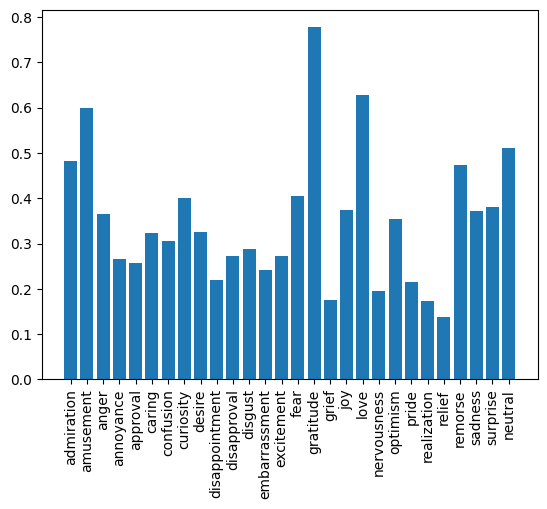

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(column_names,f1_scores)
plt.xticks(rotation=90)
plt.show()

Accuracy: 0.20317197301455794


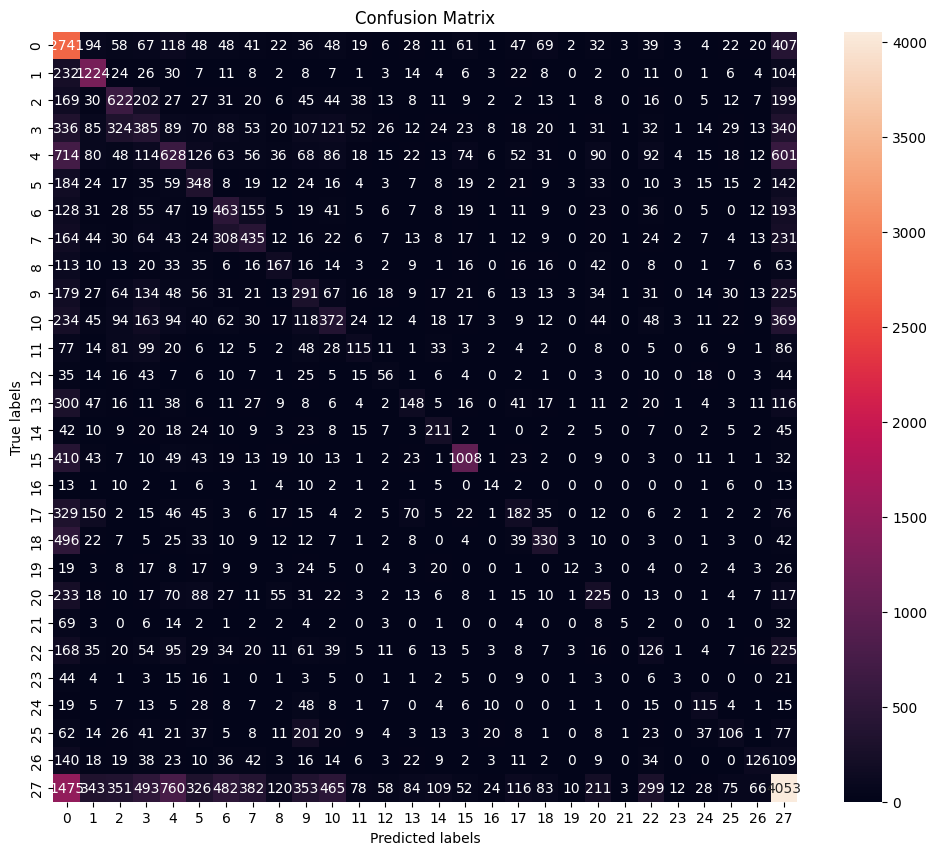

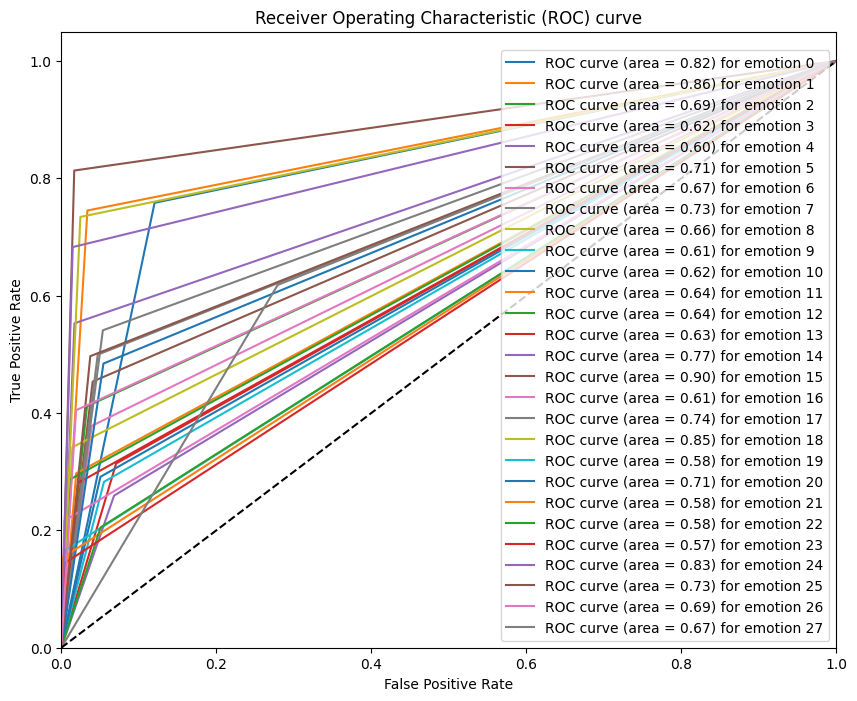

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate accuracy
y_pred_classes = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(28):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(28):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for emotion {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, np.round(y_pred))
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, np.round(y_pred), average='micro')
recall = recall_score(y_test, np.round(y_pred), average='micro')
f1 = f1_score(y_test, np.round(y_pred), average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.20317197301455794
Precision: 0.34687967906884765
Recall: 0.4933997709509554
F1 Score: 0.40736532161074945


In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def preprocess_sentence(sentence, tokenizer, maxlen):
    # Tokenize the sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)
    return padded_sequence

def predict_emotions(sentence, model, tokenizer, maxlen, threshold=0.25):
    # Preprocess the sentence
    processed_sentence = preprocess_sentence(sentence, tokenizer, maxlen)
    # Get predictions from the model
    predictions = model.predict(processed_sentence)
    # Apply thresholding
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0
    return predictions

# Example usage:
sentence = "I am feeling happy today"
# Assuming you have the trained model, tokenizer, and maxlen available
# Replace `model`, `tokenizer`, and `maxlen` with your actual trained model, tokenizer, and maxlen
predictions = predict_emotions(sentence, model, tokenizer, maxlen)
print(predictions)


1/1 [==============================] - 0s 48ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
